## Introduction

This notebook serves as experimental notebook to better understand the different transforms we apply to ImageNet images. It consists of the following sections:
- Analysis of datasets: describing the shapes of samples from each dataset and displaying an example sample
- Style augmentations: demo of the random style augmentations (composition of transforms) we use
- Individual transforms: demo of each individual transform we use
- Patch cropping: demo of our random patch cropping

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, RandomResizedCrop, RandomGrayscale, RandomHorizontalFlip, GaussianBlur, ColorJitter, RandomSolarize, ToPILImage, ToTensor, RandomCrop, CenterCrop, Resize, Normalize

# set torch seed for reproducibility when using random image augmentations
torch.manual_seed(0)

In [32]:
from src.dataset import OurPatchLocalizationDataset, OriginalPatchLocalizationDataset, image_to_patches
from src.transforms import RandomColorDropping, ColorProjection, IMAGENET_NORMALIZATION_PARAMS, IMAGENET_RESIZE

In [4]:
from typing import List, Union, Tuple
import PIL
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [5]:
import skimage
from skimage.io import imshow, imread

## Helper Functions

In [9]:
# random augmentations from ReLIC paper
RELIC_AUG_TRANSFORM = Compose([
    RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    RandomGrayscale(p=0.5),
    GaussianBlur(kernel_size=23, sigma=(0.1, 0.2)),
    RandomSolarize(0.5, p=0.5),
])

In [6]:
def display_image(
    img: torch.Tensor, 
    normalization_params=None, 
    plt_title=None
):
    
    if normalization_params is not None:
        # unnormalize image according to normalization dict
        norm_mean, norm_std = np.array(normalization_params['mean']), np.array(normalization_params['std'])
        unnormalize = Normalize(mean=-norm_mean/norm_std, std=1/norm_std)
        img = unnormalize(img)
        
    npimg = img.numpy()
    # shuffle the color channels correctly
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plot
    plt.title(plt_title)
    plt.show()

def display_dataset_sample(ds_sample: Tuple[torch.Tensor, torch.Tensor], normalization_params=None):
    samples, labels = ds_sample
    # for every sample in this dataset sample (samples_per_image parameter)
    for imgs, label in zip(samples, labels):
        display_image(torchvision.utils.make_grid(imgs), normalization_params=normalization_params, plt_title=f"label: {label.item()}")
        

## Initialize datasets & dataloaders

In [7]:
# load image paths of a previously sampled subset of ImageNet
img_paths = np.loadtxt("./data/imagenet_validation_RGB_10perc_subset.csv", dtype=str)

In [10]:
# initialization
ds_orig = OriginalPatchLocalizationDataset(img_paths=img_paths, samples_per_image=3)
dl_orig = torch.utils.data.DataLoader(ds_orig, batch_size=8, shuffle=True, num_workers=0)

ds_our = OurPatchLocalizationDataset(img_paths=img_paths, aug_transform=RELIC_AUG_TRANSFORM, samples_per_image=3)
dl_our = torch.utils.data.DataLoader(ds_our, batch_size=8, shuffle=True, num_workers=0)

#### Select image for tests

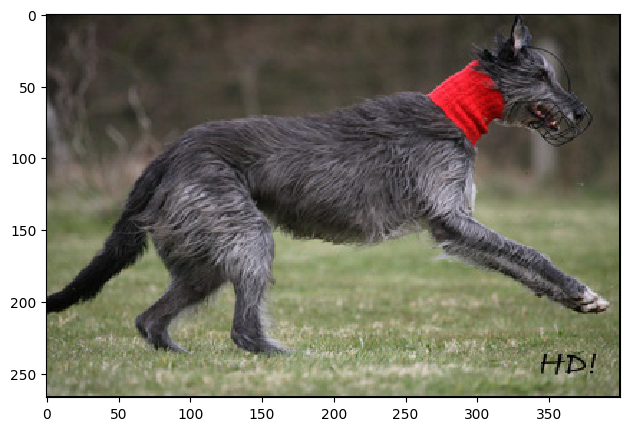

In [11]:
# select an arbitrary img_idx
img_idx=100
# display image from path
imshow(imread(ds_orig.img_paths[img_idx]))

## Analysis of OriginalPatchLocalizationDataset and OurPatchLocalizationDataset

In [12]:
# shape of the features of single dataset sample 
# samples_per_image, n_patches (2 without style augmentation, 3 with style augmentation), n_channels (RGB), img_height, img_width
print(ds_orig[0][0].shape)
print(ds_our[0][0].shape)

torch.Size([3, 2, 3, 224, 224])
torch.Size([3, 3, 3, 224, 224])


In [13]:
# shapes of features and labels in each batch of the dataloader
for X, y in dl_orig:
    print("features.shape")
    print("batch_size, samples_per_image, n_patches (2 for original, 3 for our), n_channels (RGB), img_height, img_width")
    print(X.shape)
    print("labels.shape")
    print("batch_size, samples_per_image")
    print(y.shape)
    break

features.shape
batch_size, samples_per_image, n_patches (2 for original, 3 for our), n_channels (RGB), img_height, img_width
torch.Size([8, 3, 2, 3, 224, 224])
labels.shape
batch_size, samples_per_image
torch.Size([8, 3])


In [14]:
# shapes of features and labels in each batch of the dataloader
for X, y in dl_our:
    print("features.shape")
    print("batch_size, samples_per_image, n_patches (2 for original, 3 for our), n_channels (RGB), img_height, img_width")
    print(X.shape)
    print("labels.shape")
    print("batch_size, samples_per_image")
    print(y.shape)
    break

features.shape
batch_size, samples_per_image, n_patches (2 for original, 3 for our), n_channels (RGB), img_height, img_width
torch.Size([8, 3, 3, 3, 224, 224])
labels.shape
batch_size, samples_per_image
torch.Size([8, 3])


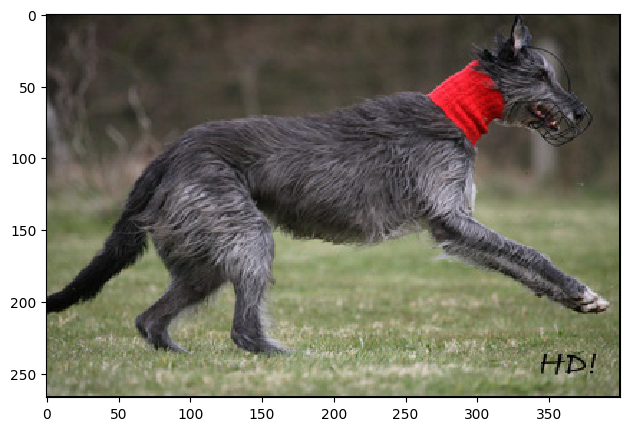

In [15]:
# display image from path
imshow(imread(ds_orig.img_paths[img_idx]))

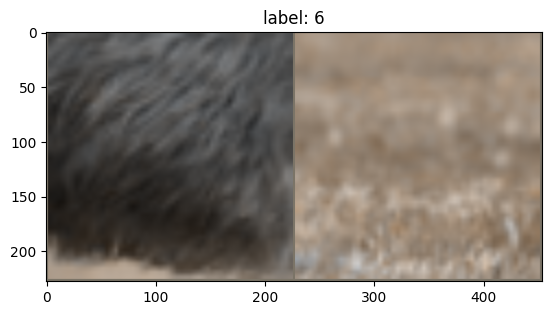

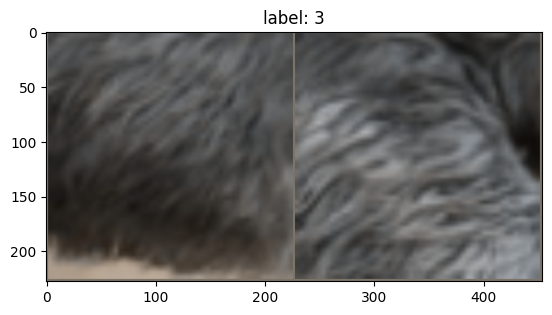

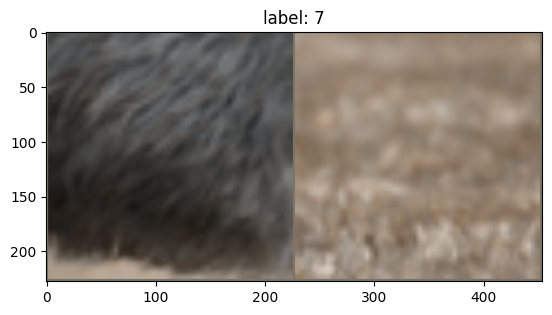

In [16]:
# display ds_orig dataset samples
display_dataset_sample(ds_orig[img_idx], normalization_params=IMAGENET_NORMALIZATION_PARAMS)

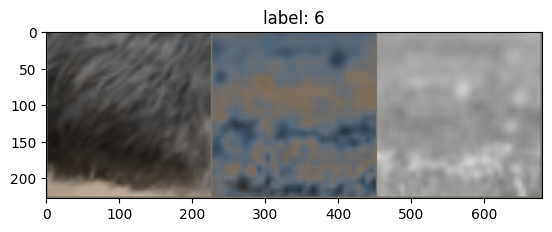

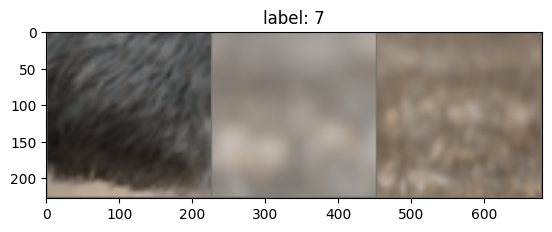

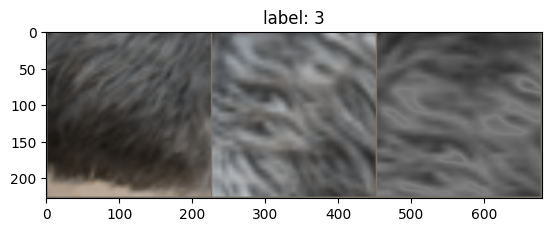

In [17]:
# display ds_our dataset samples
display_dataset_sample(ds_our[img_idx], normalization_params=IMAGENET_NORMALIZATION_PARAMS)

## Style Augmentations

In [18]:
RELIC_AUG_TRANSFORM = Compose([
    RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)), # certain
    RandomHorizontalFlip(p=0.5), # not certain
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # not certain
    RandomGrayscale(p=0.5), # not certain
    GaussianBlur(kernel_size=23, sigma=(0.1, 0.2)), # certain
    RandomSolarize(0.5, p=0.5), # not certain
])

CUSTOM_AUG_TRANSFORM = Compose([
    RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0, contrast=0.2, saturation=0, hue=0),
    RandomGrayscale(p=0.5),
    GaussianBlur(kernel_size=23, sigma=(0.1, 0.2)),
    RandomSolarize(0.5, p=0.5),
])

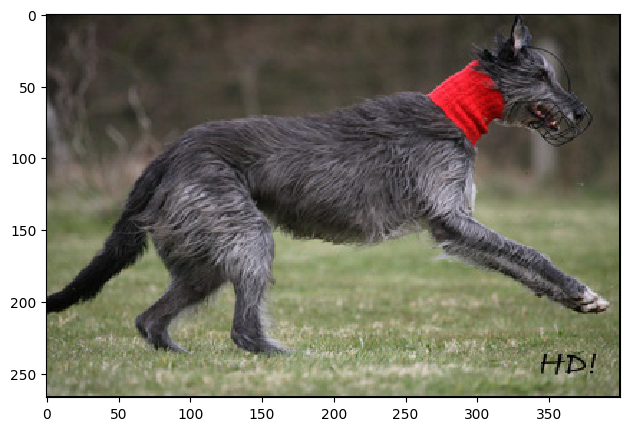

In [19]:
test_image = imread(ds_our.img_paths[img_idx])
imshow(test_image)

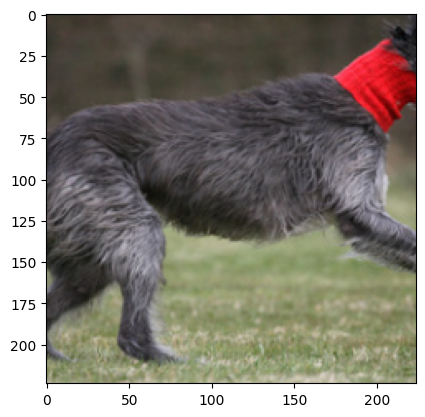

In [22]:
test_image_resized = IMAGENET_RESIZE(test_image)
display_image(test_image_resized, normalization_params=None)

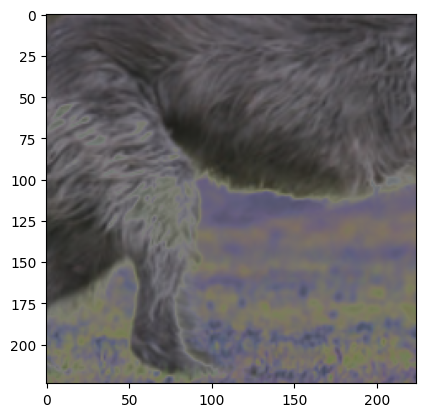

In [23]:
# display one random augmentation of the normalized test image (this cell can be re-run multiple times to get different results)
test_image_augmented = CUSTOM_AUG_TRANSFORM(test_image_resized)
display_image(test_image_augmented, normalization_params=None)

## Individual Transforms

### RandomResizedCrop

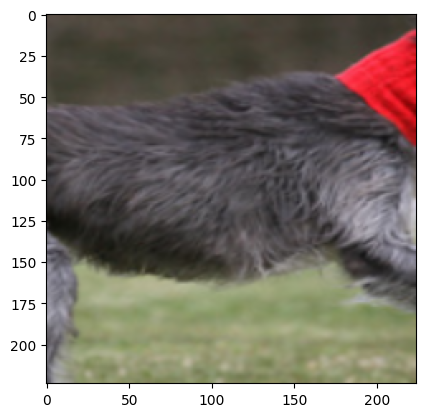

In [24]:
RRC = RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333))
test_image_augmented = RRC(test_image_resized)
display_image(test_image_augmented)

### RandomHorizontalFlip

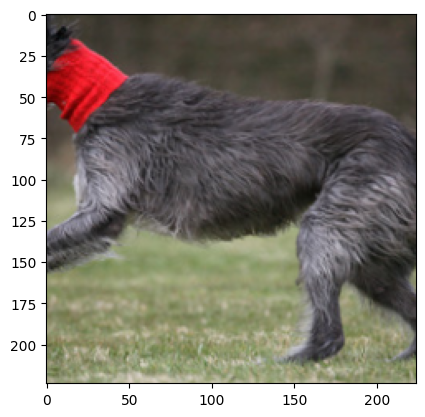

In [25]:
RHF = RandomHorizontalFlip(p=0.9)
test_image_augmented = RHF(test_image_resized)
display_image(test_image_augmented)

### ColorJitter

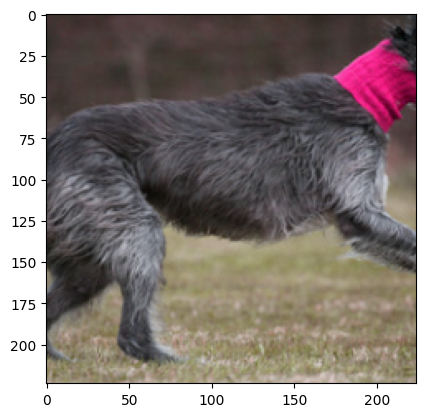

In [26]:
CJ = ColorJitter(brightness=.1, contrast=.1, saturation=.1, hue=.1)
test_image_augmented = CJ(test_image_resized)
display_image(test_image_augmented)

### RandomGrayscale

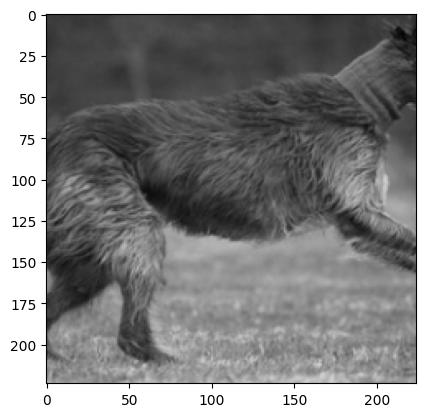

In [27]:
RG = RandomGrayscale(p=.5)
test_image_augmented = RG(test_image_resized)
display_image(test_image_augmented)

### GaussianBlur

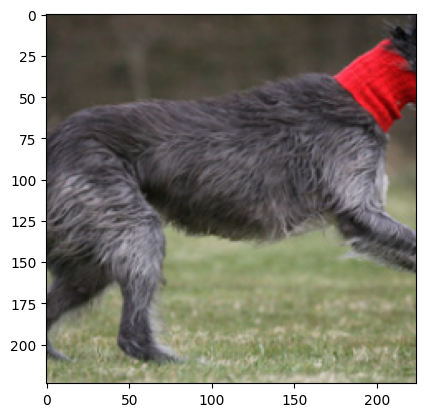

In [28]:
GB = GaussianBlur(kernel_size=23, sigma=(0.1, 0.2))
test_image_augmented = GB(test_image_resized)
display_image(test_image_augmented)

### RandomSolarize

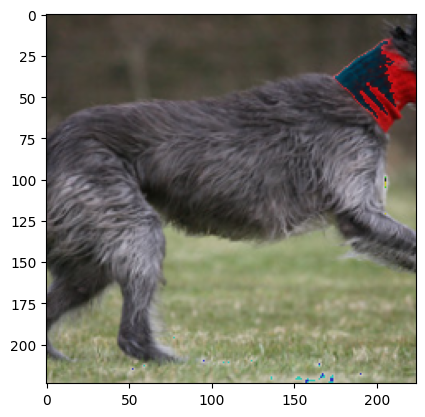

In [29]:
RS = RandomSolarize(.8, p=0.9)
test_image_augmented = RS(test_image_resized)
display_image(test_image_augmented)

### RandomColorDropping

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


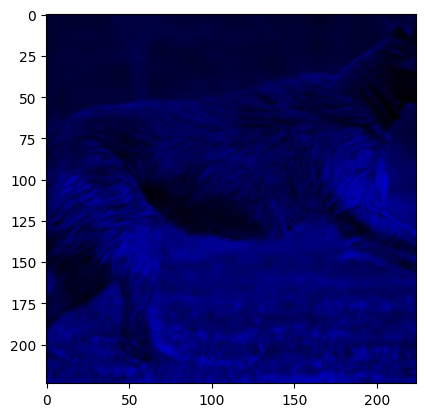

In [30]:
RCD = RandomColorDropping()
test_image_augmented = RCD(test_image_resized)
display_image(test_image_augmented)

### ColorProjection

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


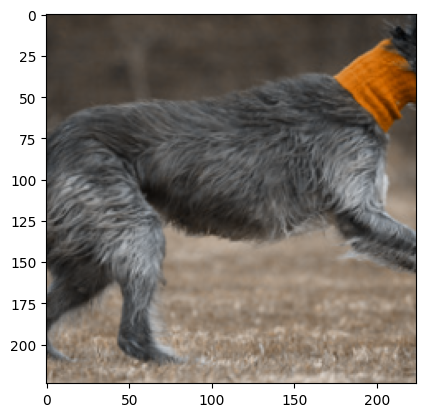

In [31]:
CP = ColorProjection()
test_image_augmented = CP(test_image_resized)
display_image(test_image_augmented)

## Patch Cropping

In [126]:
def image_to_patches(img: torch.Tensor) -> List[torch.Tensor]:
    """
    Cuts an image into 9 patches with 1/4 width and height of the original image and returns them in row major order.

    Parameters
    ----------
    img
        torch.Tensor image to be split into patches.

    Returns
    -------
    List[torch.Tensor]
        A list of the 9 patches.
    """
    splits_per_side = 3  # split of patches per image side
    img_size = img.size()[-1]
    grid_size = img_size // splits_per_side
    patch_size = img_size // 4
    gap = patch_size // 4

    # 1. center crop (ensure gap) 2. random crop (random jitter) 3. resize (to ensure img_size stays the same)
    random_jitter = Compose([CenterCrop(grid_size - gap), RandomCrop(patch_size), Resize(img_size)])
    patches = [
        random_jitter(TF.crop(img, i * grid_size, j * grid_size, grid_size, grid_size))
        for i in range(splits_per_side)
        for j in range(splits_per_side)
    ]

    return patches

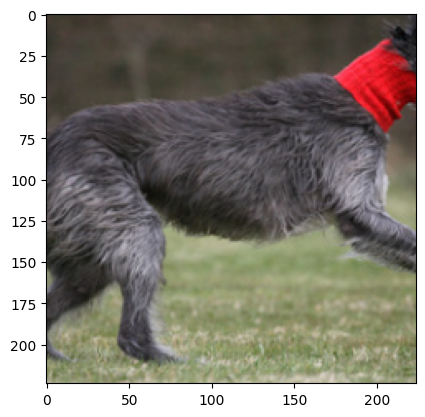

In [127]:
# original image before cropping
display_image(test_image_resized)

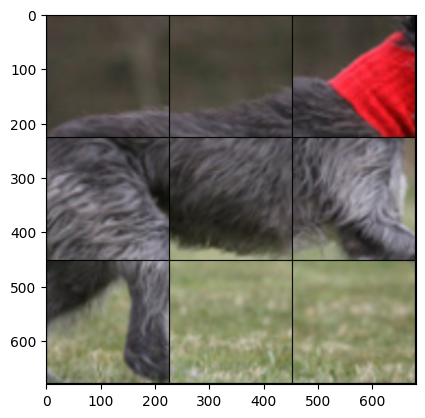

In [133]:
# this cell can be re-run to get multiple random patch crops
display_image(torchvision.utils.make_grid(image_to_patches(test_image_resized), nrow=3))